# Семинар 1 — Классические методы NLP в действии

-----

### **Цель семинара**

На этом семинаре мы пройдём полный цикл работы с текстовыми данными: от **предобработки** и **векторизации** до обучения **классификаторов** для анализа тональности отзывов. Мы сравним два классических подхода: **TF-IDF** (Term Frequency-Inverse Document Frequency) и **Word2Vec**.

-----

### **0. Установка и импорт библиотек**

В этой ячейке мы устанавливаем все необходимые библиотеки и импортируем их. Это стандартная практика для любого проекта, чтобы убедиться, что всё готово к работе. Установка некоторых библиотек может потребовать перезапуска среды colab

In [1]:
# # Установка необходимых библиотек
# !pip install pymorphy3 pymorphy3-dicts-ru  # pymorphy3 - это форк pymorphy2, поддерживаемый интузиастами для python >= 3.11
# !pip install gensim
# !pip install tqdm                          # библиотека для визуализации прогресса работы кода в ячейках

In [2]:
# Импорт библиотек
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter

# NLP библиотеки
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy3

# ML библиотеки
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Создаём папки для результатов
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [ ]:
# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Инициализируем морфологический анализатор для русского
morph = pymorphy3.MorphAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


-----

### **1. Загрузка и первичный анализ данных**

Здесь мы загрузим датасет отзывов Кинопоиск. Мы также проведём базовый анализ, чтобы понять структуру данных.

Размер датасета: 32015 отзывов
Распределение классов:
sentiment
1    27264
0     4751
Name: count, dtype: int64

Примеры отзывов:

ПОЗИТИВНЫЙ:
"Блеф» — одна из моих самых любимых комедий.

Этот фильм я наверно смотрел раз сто, нет я конечно блефую, я видел его куда больше. Не могу не выразить своё восхищение главными действующими лицами этого фильма. Начну с Адриано Челентано для которого как я считаю это лучшая роль в кино. Великолепный актёр, неплохой певец, странно что на его родине в Италии его песни мало кто слушает. Ну я думаю что и итальянцы и французы привыкли к тому, что у нас до сих их актёры популярней чем даже на своей родине. Да, такой вот парадокс. Челентано конечно профессионал своего дела, комик с серьёзным выражением лица. Он смешон ещё и потому, что одновременно так серъёзен. Адриано браво!

А теперь несколько слов об Энтони Куине. Да тот самый горбун из Нотр-дама. Собор Парижской Богоматери, оригинальная версия, кто не смотрел рекомендую. С ним как-то приключилась од

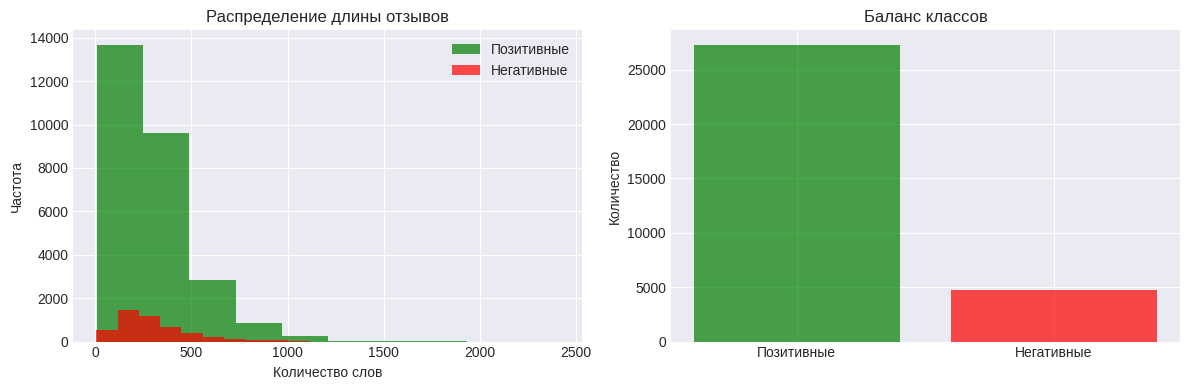

In [ ]:
# Загружаем датасет отзывов Кинопоиска
df = pd.read_json("hf://datasets/blinoff/kinopoisk/kinopoisk.jsonl", lines=True)
df['content'] = df['content'].apply(lambda x: x[1:])  # удаляем /n из начала отзывов
df = df[df['grade3'] != 'Neutral']  # фильтруем нейтральные отзывы
df['sentiment'] = df['grade3'].apply(lambda x: 1 if x == 'Good' else (0 if x == 'Bad' else None))
df['sentiment'] = df['sentiment'].astype(int)
df = df.rename(columns={'content': 'text'})
df = df[['text', 'sentiment']]

print(f"Размер датасета: {len(df)} отзывов")
print(f"Распределение классов:")
print(df['sentiment'].value_counts())
print(f"\nПримеры отзывов:")
print("\nПОЗИТИВНЫЙ:")
print(df[df['sentiment']==1].iloc[0]['text'])
print("\nНЕГАТИВНЫЙ:")
print(df[df['sentiment']==0].iloc[0]['text'])

# Базовая статистика
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

print(f"\nСтатистика длины текстов:")
print(f"Средняя длина в символах: {df['text_length'].mean():.1f}")
print(f"Среднее количество слов: {df['word_count'].mean():.1f}")

# Визуализация распределения длин и баланса классов
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df[df['sentiment']==1]['word_count'], alpha=0.7, label='Позитивные', color='green')
axes[0].hist(df[df['sentiment']==0]['word_count'], alpha=0.7, label='Негативные', color='red')
axes[0].set_xlabel('Количество слов')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение длины отзывов')
axes[0].legend()

axes[1].bar(['Позитивные', 'Негативные'], df['sentiment'].value_counts().values,
            color=['green', 'red'], alpha=0.7)
axes[1].set_ylabel('Количество')
axes[1].set_title('Баланс классов')

plt.tight_layout()
plt.show()

In [ ]:
print(f"{len(df[df['sentiment'] == 1]) / len(df) * 100}% положительных отзывов")

85.16008121193191% положительных отзывов


-----

### **2. Предобработка текста**

Качество модели напрямую зависит от качества данных. Здесь мы напишем функцию для **очистки текста**, включая:

  * Приведение к нижнему регистру
  * Удаление спецсимволов и URL
  * **Токенизацию**
  * Удаление **стоп-слов** (служебных частей речи)
  * **Лемматизацию** (приведение слова к его начальной форме)

<!-- end list -->

In [ ]:
# Загружаем стоп-слова для русского языка
stop_words_ru = set(stopwords.words('russian'))
print(f"Примеры стоп-слов: {list(stop_words_ru)[:10]}")

def preprocess_text(text, use_lemmatization=True, remove_stopwords=True):
    """
    Полный пайплайн предобработки текста.
    """

    text = text.lower()

    # 2. Удаление HTML тегов и спецсимволов
    text = re.sub(r'<.*?>', ' ', text)  # HTML теги
    text = re.sub(r'http\S+', ' ', text)  # URLs
    text = re.sub(r'[^а-яёa-z\s]', ' ', text)  # Оставляем только буквы
    text = re.sub(r'\s+', ' ', text)  # Множественные пробелы

    # 3. Токенизация по словам
    tokens = text.split()

    # 4. Удаление стоп-слов
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words_ru]

    # 5. Лемматизация
    if use_lemmatization:
        tokens = [morph.parse(token)[0].normal_form for token in tokens]

    # 6. Фильтрация коротких токенов
    tokens = [token for token in tokens if len(token) > 2]

    return ' '.join(tokens)

# Примеры предобработки
print("\n Примеры предобработки:")
sample_text = "Отличный фильм! Всем рекомендую посмотреть. Актерская игра была просто на высоте."

print(f"\nИсходный текст:\n{sample_text}")
print(f"\nБез лемматизации, со стоп-словами:\n{preprocess_text(sample_text, False, False)}")
print(f"\nБез лемматизации, без стоп-слов:\n{preprocess_text(sample_text, False, True)}")
print(f"\nС лемматизацией, без стоп-слов:\n{preprocess_text(sample_text, True, True)}")


print("\n Обрабатываем датасет...")
# удобно отслеживаем работу apply
tqdm.pandas()
df['processed_text'] = df['text'].progress_apply(
    lambda x: preprocess_text(x, use_lemmatization=True, remove_stopwords=True)
)


# Анализ частотности слов после обработки
all_words = ' '.join(df['processed_text']).split()
word_freq = Counter(all_words)

print(f"\n Топ-15 самых частых слов после обработки:")
for word, freq in word_freq.most_common(15):
    print(f"{word:15} : {freq:4} раз")

Примеры стоп-слов: ['более', 'здесь', 'ей', 'потом', 'он', 'зачем', 'для', 'сейчас', 'другой', 'нас']

 Примеры предобработки:

Исходный текст:
Отличный фильм! Всем рекомендую посмотреть. Актерская игра была просто на высоте.

Без лемматизации, со стоп-словами:
отличный фильм всем рекомендую посмотреть актерская игра была просто высоте

Без лемматизации, без стоп-слов:
отличный фильм всем рекомендую посмотреть актерская игра просто высоте

С лемматизацией, без стоп-слов:
отличный фильм весь рекомендовать посмотреть актёрский игра просто высота

 Обрабатываем датасет...


  0%|          | 0/32015 [00:00<?, ?it/s]


 Топ-15 самых частых слов после обработки:
фильм           : 158348 раз
это             : 92666 раз
который         : 75779 раз
свой            : 50500 раз
человек         : 46288 раз
очень           : 38040 раз
такой           : 32803 раз
жизнь           : 31061 раз
просто          : 30799 раз
герой           : 27476 раз
хороший         : 27403 раз
один            : 24787 раз
актёр           : 24766 раз
весь            : 23658 раз
самый           : 22851 раз


In [ ]:
# Отдельно взглянем на эмпирическом подходе
df['lower_text'] = df['text'].progress_apply(
    lambda x: preprocess_text(x, use_lemmatization=False, remove_stopwords=False)
)

  0%|          | 0/32015 [00:00<?, ?it/s]


Размер словаря после обработки: 82469 уникальных слов
Топ-20 самых частых слов:
   фильм           : 158348 раз
   это             : 92666 раз
   который         : 75779 раз
   свой            : 50500 раз
   человек         : 46288 раз
   очень           : 38040 раз
   такой           : 32803 раз
   жизнь           : 31061 раз
   просто          : 30799 раз
   герой           : 27476 раз
   хороший         : 27403 раз
   один            : 24787 раз
   актёр           : 24766 раз
   весь            : 23658 раз
   самый           : 22851 раз
   время           : 22646 раз
   смотреть        : 22038 раз
   сам             : 21332 раз
   каждый          : 21329 раз
   первый          : 20095 раз


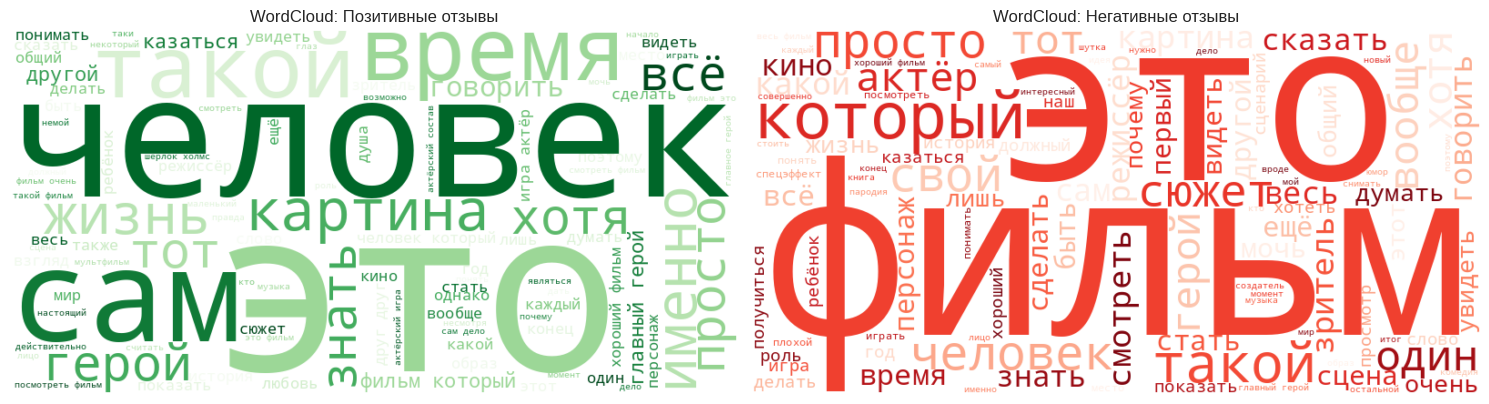

In [ ]:
from wordcloud import WordCloud
# Частотный анализ слов
all_words = ' '.join(df['processed_text']).split()
word_freq = Counter(all_words)
vocab_size = len(word_freq)

print(f"\nРазмер словаря после обработки: {vocab_size} уникальных слов")
print(f"Топ-20 самых частых слов:")
for word, freq in word_freq.most_common(20):
    print(f"   {word:15} : {freq:5} раз")



# WordCloud для позитивных и негативных отзывов
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Позитивные
positive_text = ' '.join(df[df['sentiment']==1]['processed_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens', max_words=100).generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('WordCloud: Позитивные отзывы')
axes[0].axis('off')

# Негативные
negative_text = ' '.join(df[df['sentiment']==0]['processed_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          colormap='Reds', max_words=100).generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('WordCloud: Негативные отзывы')
axes[1].axis('off')

plt.tight_layout()
plt.show()



-----

### **2.5 Baseline - на основе правила**

Взглянем на наш датасет и попробуем сделать простое правило для классификации

In [ ]:
# Разделяем данные на train/test
X = df['processed_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Размеры выборок:")
print(f"Train: {len(X_train)} примеров")
print(f"Test: {len(X_test)} примеров")



 Размеры выборок:
Train: 25612 примеров
Test: 6403 примеров


In [ ]:
df_base = pd.concat([X_train, y_train], axis=1)
print(len(df_base))

positive_text = ' '.join(df_base[df_base['sentiment']==1]['processed_text'])
negative_text = ' '.join(df_base[df_base['sentiment']==0]['processed_text'])

word_freq_p = Counter(positive_text.split())
word_freq_n = Counter(negative_text.split())

# Получаем множества ключей
positive_keys = set(word_freq_p.keys())
negative_keys = set(word_freq_n.keys())

# Находим уникальные слова для каждого словаря
unique_positive = positive_keys - negative_keys  # Слова ТОЛЬКО в позитивных
unique_negative = negative_keys - positive_keys  # Слова ТОЛЬКО в негативных

# Фильтруем словари, оставляя только уникальные слова
word_freq_p = Counter({word: word_freq_p[word] for word in unique_positive})
word_freq_n = Counter({word: word_freq_n[word] for word in unique_negative})

print(f"Топ-20 уникальных частых слов позитивных отзывов:")

vocab_size = len(word_freq_p)
for word, freq in word_freq_p.most_common(20):
    print(f"   {word:15} : {freq:5} раз")


print(f"Топ-20 уникальных частых слов негативных отзывов:")

vocab_size = len(word_freq_n)
for word, freq in word_freq_n.most_common(20):
    print(f"   {word:15} : {freq:5} раз")

25612
Топ-20 уникальных частых слов позитивных отзывов:
   нэш             :   272 раз
   прота           :   179 раз
   балтый          :   158 раз
   рудить          :   154 раз
   леонард         :   146 раз
   тихиро          :   133 раз
   борден          :   131 раз
   аладдин         :   130 раз
   брэддок         :   117 раз
   кларисса        :   116 раз
   белля           :   113 раз
   ферлонг         :   112 раз
   макфлай         :   109 раз
   симб            :   107 раз
   уокен           :    99 раз
   сжиматься       :    95 раз
   кертис          :    94 раз
   райдер          :    92 раз
   wall            :    91 раз
   джонатан        :    85 раз
Топ-20 уникальных частых слов негативных отзывов:
   кукарача        :    34 раз
   сукаченко       :    15 раз
   булдаков        :    15 раз
   бомбоубежище    :    14 раз
   дзенга          :    14 раз
   никакущий       :    14 раз
   саакашвили      :    13 раз
   портос          :    12 раз
   крапивенец      :    11

In [ ]:
negative_text = ' '.join(df_base[df_base['sentiment']==0]['processed_text'])
word_freq_n = Counter(negative_text.split())
vocab_size = len(word_freq_n)
for word, freq in word_freq_n.most_common(80)[20:]:
    print(f"   {word:15} : {freq:5} раз")

   время           :  2269 раз
   вообще          :  2240 раз
   игра            :  2202 раз
   мочь            :  2095 раз
   тот             :  2032 раз
   всё             :  2030 раз
   режиссёр        :  2003 раз
   какой           :  1946 раз
   говорить        :  1943 раз
   хотя            :  1855 раз
   картина         :  1832 раз
   наш             :  1821 раз
   главный         :  1810 раз
   зритель         :  1738 раз
   просмотр        :  1697 раз
   посмотреть      :  1687 раз
   плохой          :  1612 раз
   знать           :  1609 раз
   сцена           :  1592 раз
   год             :  1589 раз
   роль            :  1528 раз
   сделать         :  1496 раз
   хотеть          :  1479 раз
   этот            :  1471 раз
   часть           :  1468 раз
   конец           :  1460 раз
   быть            :  1423 раз
   стать           :  1397 раз
   другой          :  1396 раз
   мой             :  1369 раз
   персонаж        :  1341 раз
   видеть          :  1335 раз
   слово

In [ ]:
pred_base = pd.concat([X_test, y_test], axis=1)
pred_base['words'] = pred_base['processed_text'].apply(lambda x: x.split())
pred_base['pred'] = pred_base['words'].apply(lambda x: 0 if 'плохой' in x or 'никакой' in x else 1)
y_pred_base = pred_base['pred']

Результаты базового подхода:
Accuracy:  0.747
Precision: 0.892
Recall:    0.799
F1-score:  0.843
Точность на негативных отзывах:  0.444


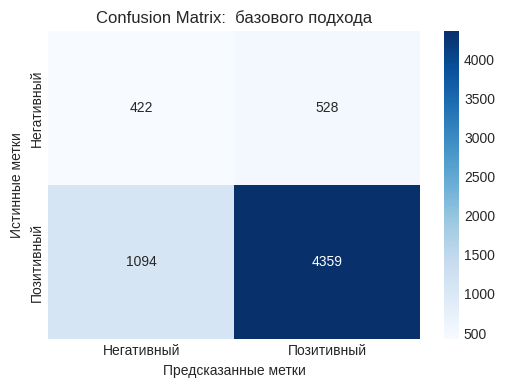

In [ ]:
# Метрики
accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)

print(f"Результаты базового подхода:")
print(f"Accuracy:  {accuracy_base:.3f}")
print(f"Precision: {precision_base:.3f}")
print(f"Recall:    {recall_base:.3f}")
print(f"F1-score:  {f1_base:.3f}")

# Confusion Matrix
cm_base = confusion_matrix(y_test, y_pred_base)

print(f"Точность на негативных отзывах:  {cm_base[0,0] / (cm_base[0,1] + cm_base[0,0]):.3f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Негативный', 'Позитивный'],
            yticklabels=['Негативный', 'Позитивный'])
plt.title('Confusion Matrix:  базового подхода')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()

-----

### **3. TF-IDF + LogisticRegression**

**TF-IDF** — это классический метод векторизации текста, который отражает важность слова для документа в контексте всего корпуса. Мы используем его, чтобы создать наш первый, **базовый классификатор**, и оценить его производительность.


 Создаём TF-IDF представление...
 TF-IDF матрица создана
Размерность: (25612, 1000)
Разреженность: 8.34%

 Обучаем Logistic Regression...

 Результаты TF-IDF + LogisticRegression:
Accuracy:  0.934
Precision: 0.947
Recall:    0.977
F1-score:  0.962
Точность на негативных отзывах:  0.686


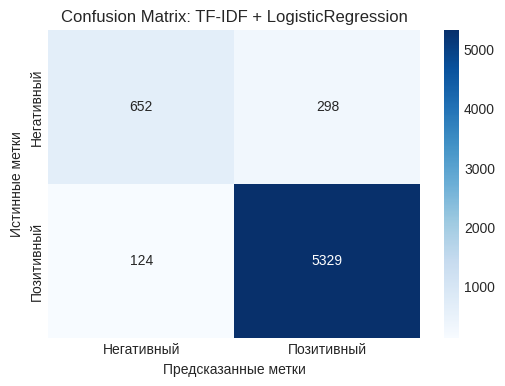


 Топ-10 признаков для ПОЗИТИВНОГО класса:
каждый               : 5.107
великолепный         : 4.722
потрясать            : 4.692
отличный             : 4.568
жизнь                : 3.583
отлично              : 3.438
именно               : 3.288
приятно              : 3.231
очень                : 3.111
настоящий            : 2.923

 Топ-10 признаков для НЕГАТИВНОГО класса:
скучный              : -4.722
никакой              : -4.422
бред                 : -4.140
глупый               : -4.109
единственный         : -3.759
ужасный              : -3.712
плохой               : -3.689
вообще               : -3.663
никак                : -3.627
деньга               : -3.564


In [ ]:
# Создаём TF-IDF векторизатор
print("\n Создаём TF-IDF представление...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,      # Максимум 1000 признаков
    min_df=2,               # Минимум в 2 документах
    max_df=0.8,             # Максимум в 80% документов
    ngram_range=(1, 2),     # Униграммы и биграммы
    lowercase=False         # Уже в нижнем регистре
)

# Обучаем векторизатор и трансформируем данные
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f" TF-IDF матрица создана")
print(f"Размерность: {X_train_tfidf.shape}")
print(f"Разреженность: {(X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.2%}")

# Обучаем LogisticRegression
print("\n Обучаем Logistic Regression...")

lr_tfidf = LogisticRegression(
    C=1.0,
    solver='liblinear',
    random_state=42
)

lr_tfidf.fit(X_train_tfidf, y_train)

# Предсказания
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

# Метрики
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
precision_tfidf = precision_score(y_test, y_pred_tfidf)
recall_tfidf = recall_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

print(f"\n Результаты TF-IDF + LogisticRegression:")
print(f"Accuracy:  {accuracy_tfidf:.3f}")
print(f"Precision: {precision_tfidf:.3f}")
print(f"Recall:    {recall_tfidf:.3f}")
print(f"F1-score:  {f1_tfidf:.3f}")

# Confusion Matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

print(f"Точность на негативных отзывах:  {cm_tfidf[0,0] / (cm_tfidf[0,1] + cm_tfidf[0,0]):.3f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Негативный', 'Позитивный'],
            yticklabels=['Негативный', 'Позитивный'])
plt.title('Confusion Matrix: TF-IDF + LogisticRegression')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()

# Анализ важности признаков
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_tfidf.coef_[0]

# Топ позитивные и негативные признаки
top_positive_idx = np.argsort(coefficients)[-10:][::-1]
top_negative_idx = np.argsort(coefficients)[:10]

print("\n Топ-10 признаков для ПОЗИТИВНОГО класса:")
for idx in top_positive_idx:
    print(f"{feature_names[idx]:20} : {coefficients[idx]:.3f}")

print("\n Топ-10 признаков для НЕГАТИВНОГО класса:")
for idx in top_negative_idx:
    print(f"{feature_names[idx]:20} : {coefficients[idx]:.3f}")

-----

### **4. Word2Vec - обучение модели**

**Word2Vec** — это нейросетевая модель, которая учится представлять слова в виде плотных векторов (эмбеддингов). Слова со схожим значением будут иметь похожие векторы. Мы обучим модель на нашем корпусе текста.

In [ ]:
# Подготовка данных для Word2Vec (список списков токенов)
tokenized_texts = [text.split() for text in df['processed_text']]

print(f" Подготовлено {len(tokenized_texts)} текстов для обучения")
print(f"Пример токенизированного текста: {tokenized_texts[0][:10]}")

# Обучаем Word2Vec
print("\n Обучаем Word2Vec модель...")

w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,      # Размерность векторов
    window=5,             # Размер контекстного окна
    min_count=2,          # Минимальная частота слова
    workers=4,            # Параллельность
    sg=1,                 # Skip-gram (0 = CBOW)
    epochs=50,            # Количество эпох
    seed=42
)

print(f" Word2Vec обучен")
print(f"Размер словаря: {len(w2v_model.wv)}")
print(f"Размерность векторов: {w2v_model.wv.vector_size}")

# Примеры семантических отношений
print("\n Примеры семантических отношений:")

test_words = ['отличный', 'ужасный', 'товар', 'качество']

for word in test_words:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=5)
        print(f"\nПохожие на '{word}':")
        for sim_word, score in similar:
            print(f"  {sim_word:15} : {score:.3f}")
    else:
        print(f"\nСлово '{word}' не найдено в словаре")

# Сохраняем модель
w2v_model.save('models/word2vec_model.bin')
print("\n Модель сохранена в models/word2vec_model.bin")

 Подготовлено 32015 текстов для обучения
Пример токенизированного текста: ['блеф', 'один', 'мой', 'самый', 'любимый', 'комедия', 'фильм', 'наверно', 'смотреть', 'сто']

 Обучаем Word2Vec модель...
 Word2Vec обучен
Размер словаря: 48546
Размерность векторов: 100

 Примеры семантических отношений:

Похожие на 'отличный':
  великолепный    : 0.847
  превосходный    : 0.840
  замечательный   : 0.828
  потрясать       : 0.766
  классный        : 0.764

Похожие на 'ужасный':
  отвратительный  : 0.750
  кошмарный       : 0.713
  страшный        : 0.709
  ужасающий       : 0.705
  жуткий          : 0.688

Похожие на 'товар':
  обвёртка        : 0.535
  покупать        : 0.532
  устаревание     : 0.520
  эмалировать     : 0.518
  утварь          : 0.514

Похожие на 'качество':
  показатель      : 0.576
  андреано        : 0.544
  уровень         : 0.540
  коламбусовский  : 0.537
  гарант          : 0.534

 Модель сохранена в models/word2vec_model.bin


-----

### **5. Word2Vec + LogisticRegression**

Word2Vec даёт векторы для слов, но нам нужен вектор для целого документа. Мы можем получить его, усреднив векторы всех слов в документе. Этот усреднённый вектор затем будет подан на вход в классификатор.

Преобразуем тексты в векторы...


  0%|          | 0/25612 [00:00<?, ?it/s]

  0%|          | 0/6403 [00:00<?, ?it/s]

Векторизация завершена
Размерность: (25612, 100)

Обучаем Logistic Regression на Word2Vec...

Результаты Word2Vec + LogisticRegression:
Accuracy:  0.938
Precision: 0.952
Recall:    0.976
F1-score:  0.964
Точность на негативных отзывах:  0.719


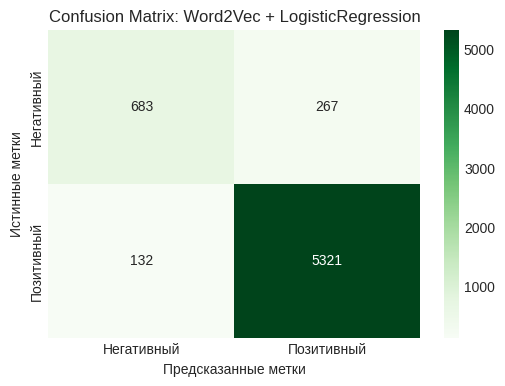

In [ ]:
def text_to_vector(text, model):
    """
    Преобразует текст в вектор путём усреднения векторов слов.
    """
    words = text.split()
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])

    if len(word_vectors) == 0:
        # Если ни одно слово не найдено, возвращаем нулевой вектор
        return np.zeros(model.wv.vector_size)

    # Усредняем векторы слов
    return np.mean(word_vectors, axis=0)

# Преобразуем тексты в векторы
print("Преобразуем тексты в векторы...")

X_train_w2v = np.array([text_to_vector(text, w2v_model) for text in tqdm(X_train)])
X_test_w2v = np.array([text_to_vector(text, w2v_model) for text in tqdm(X_test)])

print(f"Векторизация завершена")
print(f"Размерность: {X_train_w2v.shape}")

# Обучаем LogisticRegression на Word2Vec векторах
print("\nОбучаем Logistic Regression на Word2Vec...")

lr_w2v = LogisticRegression(
    C=1.0,
    solver='liblinear',
    random_state=42
)

lr_w2v.fit(X_train_w2v, y_train)

# Предсказания
y_pred_w2v = lr_w2v.predict(X_test_w2v)

# Метрики
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
precision_w2v = precision_score(y_test, y_pred_w2v)
recall_w2v = recall_score(y_test, y_pred_w2v)
f1_w2v = f1_score(y_test, y_pred_w2v)

print(f"\nРезультаты Word2Vec + LogisticRegression:")
print(f"Accuracy:  {accuracy_w2v:.3f}")
print(f"Precision: {precision_w2v:.3f}")
print(f"Recall:    {recall_w2v:.3f}")
print(f"F1-score:  {f1_w2v:.3f}")

# Confusion Matrix
cm_w2v = confusion_matrix(y_test, y_pred_w2v)

print(f"Точность на негативных отзывах:  {cm_w2v[0,0] / (cm_w2v[0,1] + cm_w2v[0,0]):.3f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Негативный', 'Позитивный'],
            yticklabels=['Негативный', 'Позитивный'])
plt.title('Confusion Matrix: Word2Vec + LogisticRegression')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()

-----

### **6. Сравнение методов**

Мы сравним результаты двух подходов по ключевым метрикам.


Сравнительная таблица метрик:
            Метод  Accuracy  Precision   Recall  F1-Score
  TF-IDF + LogReg  0.934093   0.947041 0.977260  0.961913
Word2Vec + LogReg  0.937685   0.952219 0.975793  0.963862


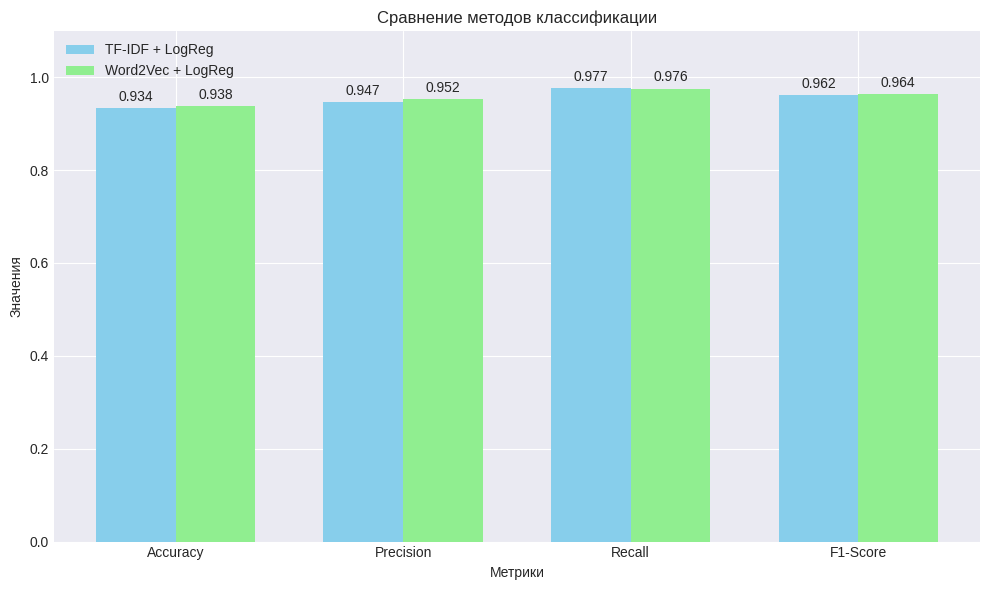


Анализ ошибок классификации:

Статистика ошибок:
Ошибки только TF-IDF: 152
Ошибки только Word2Vec: 129
Общие ошибки: 270

Пример текста, который оба метода классифицировали неправильно:
Текст:       Вот пристали к фильму!



И сценарий вам плох, и волосы у Вдовиченкова длинные и взрывы не так взрываются.



А по мне — так нормальный фильм. И то, что его тут так много ругают, говорит лишь об одном — что это все заказуха. Проплаченный антипиар.



На самом деле Вдовиченков брутален, Канделаки (о, ужас!) умеет говорить медленно, а спецэффекты самые эффективные. Получше чем у зарубежных товарищей некоторых.



Смотрите кино — разного и много!
      
Истинная метка: 1
TF-IDF предсказал: 0
Word2Vec предсказал: 0


In [ ]:
# Создаём сравнительную таблицу
comparison_df = pd.DataFrame({
    'Метод': ['TF-IDF + LogReg', 'Word2Vec + LogReg'],
    'Accuracy': [accuracy_tfidf, accuracy_w2v],
    'Precision': [precision_tfidf, precision_w2v],
    'Recall': [recall_tfidf, recall_w2v],
    'F1-Score': [f1_tfidf, f1_w2v]
})

print("\nСравнительная таблица метрик:")
print(comparison_df.to_string(index=False))

# Визуализация сравнения
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df.columns[1:]))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df.iloc[0, 1:], width,
               label='TF-IDF + LogReg', color='skyblue')
bars2 = ax.bar(x + width/2, comparison_df.iloc[1, 1:], width,
               label='Word2Vec + LogReg', color='lightgreen')

ax.set_xlabel('Метрики')
ax.set_ylabel('Значения')
ax.set_title('Сравнение методов классификации')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.columns[1:])
ax.legend()
ax.set_ylim([0, 1.1])

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Анализ ошибок
print("\nАнализ ошибок классификации:")

# Находим индексы неправильных предсказаний
errors_tfidf = X_test[y_test != y_pred_tfidf].index
errors_w2v = X_test[y_test != y_pred_w2v].index

# Ошибки только TF-IDF
only_tfidf_errors = set(errors_tfidf) - set(errors_w2v)
# Ошибки только Word2Vec
only_w2v_errors = set(errors_w2v) - set(errors_tfidf)
# Общие ошибки
common_errors = set(errors_tfidf) & set(errors_w2v)

print(f"\nСтатистика ошибок:")
print(f"Ошибки только TF-IDF: {len(only_tfidf_errors)}")
print(f"Ошибки только Word2Vec: {len(only_w2v_errors)}")
print(f"Общие ошибки: {len(common_errors)}")

# Примеры ошибок
if len(common_errors) > 0:
    print("\nПример текста, который оба метода классифицировали неправильно:")
    error_idx = list(common_errors)[0]
    print(f"Текст: {df.loc[error_idx, 'text']}")
    print(f"Истинная метка: {df.loc[error_idx, 'sentiment']}")
    print(f"TF-IDF предсказал: {y_pred_tfidf[list(X_test.index).index(error_idx)]}")
    print(f"Word2Vec предсказал: {y_pred_w2v[list(X_test.index).index(error_idx)]}")

**У нас получилось выделить очень интересный отзыв. Он построен на сарказме, где автор формально хвалит фильм, но делает это через намеренно преувеличенные, абсурдные или двусмысленные формулировки, чтобы высмеять критиков**

TF-IDF анализирует частоту ключевых слов, но не их взаимосвязь. Например:
Слова «о, ужас!», «заказуха», «антипиар» имеют сильный негативный окрас в лексиконах тональности.
Однако в контексте отзыва они служат для защиты фильма («критики — проплаченные, а их претензии смешны»).
Модель может пометить отзыв как негативный из-за этих слов, хотя общий смысл — позитивный.

Word2Vec:
Учитывает контекст близости слов, но не понимает иронию, сарказм и стилистической игры.
Также Word2Vec не улавливает интонацию, скобки, восклицания, риторические вопросы — всё это важно для понимания иронии.
Векторы слов, которые усредняются на уровне предложений имеют отрицательный окрас, без учета контекста, поэтому и модель определяет комментарий как негативный

-----

### **БЛОК 7: Мини-задания для самостоятельной работы**

Эта секция содержит идеи для дальнейших экспериментов, чтобы вы могли углубить свои знания и навыки в NLP. Также отсюда можно взять идеи для выполнения домашней работы. Выход за границы ДЗ будет поощряться дополнительными баллами

ЗАДАНИЯ ДЛЯ САМОСТОЯТЕЛЬНОЙ РАБОТЫ:

1. ЭКСПЕРИМЕНТ С ПАРАМЕТРАМИ TF-IDF:
   - Попробуйте изменить `ngram_range` на `(1,3)` для включения триграмм
   - Измените `max_features` на 500 и 2000, сравните результаты
   - Отключите удаление стоп-слов и посмотрите, как изменится качество

2. ЭКСПЕРИМЕНТ С WORD2VEC:
   - Измените размерность векторов (`vector_size`) на 50, 200, 300
   - Попробуйте CBOW вместо Skip-gram (`sg=0`)
   - Измените размер окна (`window`) на 3, 7, 10

3. АЛЬТЕРНАТИВНЫЕ СПОСОБЫ АГРЕГАЦИИ:
   - Вместо усреднения попробуйте:
     * Взвешенное среднее по TF-IDF весам
     * Максимум/минимум по каждой размерности
     * Конкатенация среднего и максимума

4. ДОБАВЬТЕ SVM КЛАССИФИКАТОР:
   - Обучите SVM с разными ядрами (`linear`, `rbf`)
   - Сравните с LogisticRegression

5. ВИЗУАЛИЗАЦИЯ ЭМБЕДДИНГОВ:
   - Используйте t-SNE для визуализации Word2Vec векторов слов
   - Покажите кластеры позитивных и негативных слов

6. КРОСС-ВАЛИДАЦИЯ:
   - Реализуйте 5-fold кросс-валидацию
   - Получите доверительные интервалы для метрик

7. АНАЛИЗ ВАЖНОСТИ:
   - Для Word2Vec используйте LIME или SHAP
   - Объясните предсказания для конкретных примеров



## Дополнительные ресурсы

Habr: [Пишем свой TF-IDF](https://habr.com/ru/articles/836706/)

Визуализация: [Word2Vec](projector.tensorflow.org)